In [1]:
from tqdm import tqdm

In [2]:
from frozen_yoghourt import *

Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')
Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc', line 3 ('backend: TkAgg')
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/aqua/operators/operator_globals.py:48: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))


In [3]:
## Define general loss function (Cost1)

loss = lambda y_hat, y: np.mean(np.linalg.norm(np.abs(np.abs(y_hat) - y), axis = 0))/np.sqrt(2)
# loss = lambda y_hat, y: np.sum(np.abs(y_hat - np.abs(y)))



## Total Difference function (Cost2)
def cx_diff(circ, n):
    
    y_hat = get(circ, nice = False)
    
    qc = q(n+1)
    qc.mct(list(range(n)), n)
    y = get(qc, nice = False)
    
    diff = np.sum(np.abs(np.abs(y_hat) - np.round(y)))
    
    return diff

In [4]:
## This function will calculate the cost for all the circuit that is 
## made up of cx with target as the last qubit, and U gates in between

### Visualization Tools

In [5]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import math
%matplotlib inline
    
def live_plot(x, y1, len_x):
    clear_output(wait=True)
    
    ### y1
    if 7 <= len(x) <= 15:
        x_axis_len = len(x)
    elif len(x) < 7:
        x_axis_len = 7
    else:
        x_axis_len = 15
    plt.figure(figsize=(x_axis_len,5))
    
    xint = range(min(x), math.ceil(max(x))+1)
    plt.xticks(xint)
    plt.yscale('log')
    
    x = [float(i) for i in x]
    y1 = [float(i) for i in y1]
    
    plt.plot(x, y1, '-o', label='Optimization process', color='k') 

    plt.title('General Cost Over Training')
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.ylabel('General cost')
    plt.show()

### Lowest Random Parameters

In [6]:
def lrp(n, order, no_val, cost2 = False):
    
    """
    Find the lowest random parametes for an individual circuit
    """
    cost1_list = []
    cost2_list = []
    
    if cost2:

        for i in tqdm(range(200_000, 200_000+no_val)):
            np.random.seed(i)
            angles = np.random.uniform(0, 2*np.pi, 3*(len(order)+1))

            # Cost 1
            cost1_list.append(general_cost(angles))

            # Cost 2
            circ = general_circ(n, order, angles)
            cost2_list.append(cx_diff(np.abs(get(circ, nice = False)), n))
            
        index1 = np.where(cost1_list == min(cost1_list))[0][0]

        print(f"The lowest cost 1 is {cost1_list[index1]}")

        np.random.seed(index1)
        low_a = np.random.uniform(0, 2*np.pi, 3*(len(order)+1))
            
        index2 = np.where(cost2_list == min(cost2_list))[0][0]

        print(f"The lowest cost 2 is {cost2_list[index2]}")

        np.random.seed(index2)
        low_b = np.random.uniform(0, 2*np.pi, 3*(len(order)+1))
        
        return low_a, low_b
    
    else:
        
        for i in tqdm(range(0, no_val)):
            np.random.seed(i)
            angles = np.random.uniform(0, 2*np.pi, 3*(len(order)+1))

            # Cost 1
            cost1_list.append(general_cost(angles))
        

    index1 = np.where(cost1_list == min(cost1_list))[0][0]

    print(f"The lowest cost 1 is {cost1_list[index1]}")

    np.random.seed(index1)
    low_a = np.random.uniform(0, 2*np.pi, 3*(len(order)+1))
    
    return low_a

### General Circuit Builder

In [7]:
def general_circ(n, order, angles):
    
    
    """
    Create a circuit with all the angles and cx in order
    
    Parameters:
    -----------
    n: int
        The number of control bits in the circuit
    order: list
        The order of the indices of control bits from left to right
    angles: ndarray
        Array of euler angles for the U gates
        
    Returns:
    --------
    circ: QuantumCircuit
        Circuit with all the angles and cx in order
        
    """
    
    circ = q(n+1)

    for i, control in enumerate(order):
        circ.u(angles[3*i], angles[3*i+1], angles[3*i+2], n)
        circ.cx(control, n)

    circ.u(angles[-3], angles[-2], angles[-1], n)
    
    return circ

### General Cost Function

In [27]:
def general_cost(angles):
    
    ### Remember to write the values for n and order here because sp only allows function with 1 parameters
    
    n = 5
    order = [0, 4, 3, 1, 2, 1, 3, 4, 0, 4, 3, 1, 2, 1, 3, 4, 0, 4, 3, 1, 2, 1, 3, 4, 0, 4, 3, 1, 2, 1, 3, 4 ]
    
    """
    
    This function will calculate the cost for all the circuit that is made up of cx with target as the last qubit, 
    and U gates in between
    
    Parameters:
    -----------
    n: int
        The number of control bits in the circuit
    order: list
        The order of the indices of control bits from left to right
    angles: ndarray
        Array of euler angles for the U gates
        
        
    Returns:
    --------
    cost: float
        Average cost of all expected outputs
        
    """
    
    if len(order)+1 == len(angles):
        return 'Error, the circuit is not correct'
    
    m = len(order)
    
    # Initialize Parameter list
    U_list = [U(angles[3*i], angles[3*i + 1], angles[3*i+2]) for i in range(m+1)]

    cost = 0

    # Create the list of inputs as tuples (q0, q1, q2, ..., q2^n)
    input_list = product([I, X], repeat = n)

    # Create the list of output
    output_list = [I]*(2**n)
    output_list[-1] = X

    for j, inp in enumerate(input_list):

        Uh_list = list.copy(U_list)

        for k, index in enumerate(order):
            Uh_list.insert(2*k+1, inp[index])

        Uhi = mat_mul(*reversed(Uh_list))
        
        if j == 2**n -1:
            cost+= loss(Uhi, output_list[j])
        else:
            cost += loss(Uhi, output_list[j])  
        
    cost /= 2**n
    
    return cost

### Testing Different Architecture

In [28]:
# Optimizers List
"Nelder-Mead" , "Powell" , "CG" , "BFGS" , "Newton-CG" , "L-BFGS-B" , "TNC" , "COBYLA" 
"SLSQP" , "trust-constr", "dogleg" , "trust-ncg" , "trust-exact" , "trust-krylov"

('SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov')

In [29]:
# Parameters

n = 5
order = [0, 4, 3, 1, 2, 1, 3, 4, 0, 4, 3, 1, 2, 1, 3, 4, 0, 4, 3, 1, 2, 1, 3, 4, 0, 4, 3, 1, 2, 1, 3, 4 ]

In [30]:
# Find Lowest Random Parameters
# angles = lrp(n, order, 50_000)

angles = np.random.uniform(0, 2*np.pi, len(order)*3 + 3)

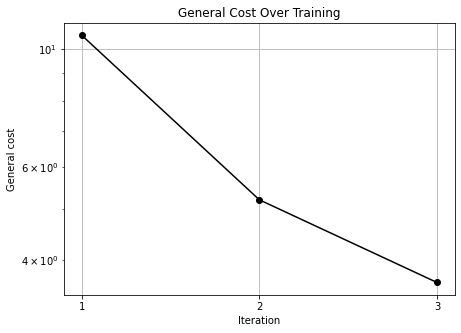

 30%|███       | 3/10 [03:55<09:10, 78.66s/it]

In [ ]:
# Further Optimization Iterations

reps = 10

idx = []
cost1 = []
# cost2 = []

for j in tqdm(range(reps)):
    result = sp.optimize.minimize(general_cost, angles, method = "Nelder-Mead" )
    angles = result.x
    
    # Cost 1
    cost1.append(general_cost(angles)*2**(n+2))
    
    '''# Cost 2
    circ = general_circ(n, order, angles)
    cost2.append(cx_diff(np.abs(get(circ, nice = False)), n))'''
    
    idx.append(j + 1)
    live_plot(idx, cost1, 10)
    

In [14]:
result.x

array([  5.28874116,   4.7521905 ,   2.01320771,   4.83686233,
         3.84064595,   3.5609586 ,   4.23298363,   1.26416377,
         4.76129933,   3.99533247,   4.01168464,   3.3369631 ,
         6.19509509,   0.03853405,   3.03946058,   0.60475879,
         2.23009084,   5.67910928,   2.58506644,   1.09815002,
         1.97056956,   0.98938175,   5.89306605,   3.40473699,
         3.69347829,   1.62649766,   2.16306472,   3.29002856,
         0.02078916,   3.10407992,   5.15575647,   3.49921287,
         4.43785947,   1.9167509 ,   3.53881092,   3.51877203,
         4.11444591,   4.9612332 ,   4.30715635,   2.13602505,
         3.03723569,   6.16288743,   0.4464301 ,   1.157934  ,
         4.75783676,   5.25203993,   1.22498709,   3.72351535,
         3.11126278,   0.22017289,   1.72629547,   3.67431846,
       -15.32484104,   3.09710002])

In [15]:
### Review CX cost of the circuit
print(f'The circuit will have cost of {len(order)*10 + len(order) +1}')

The circuit will have cost of 188


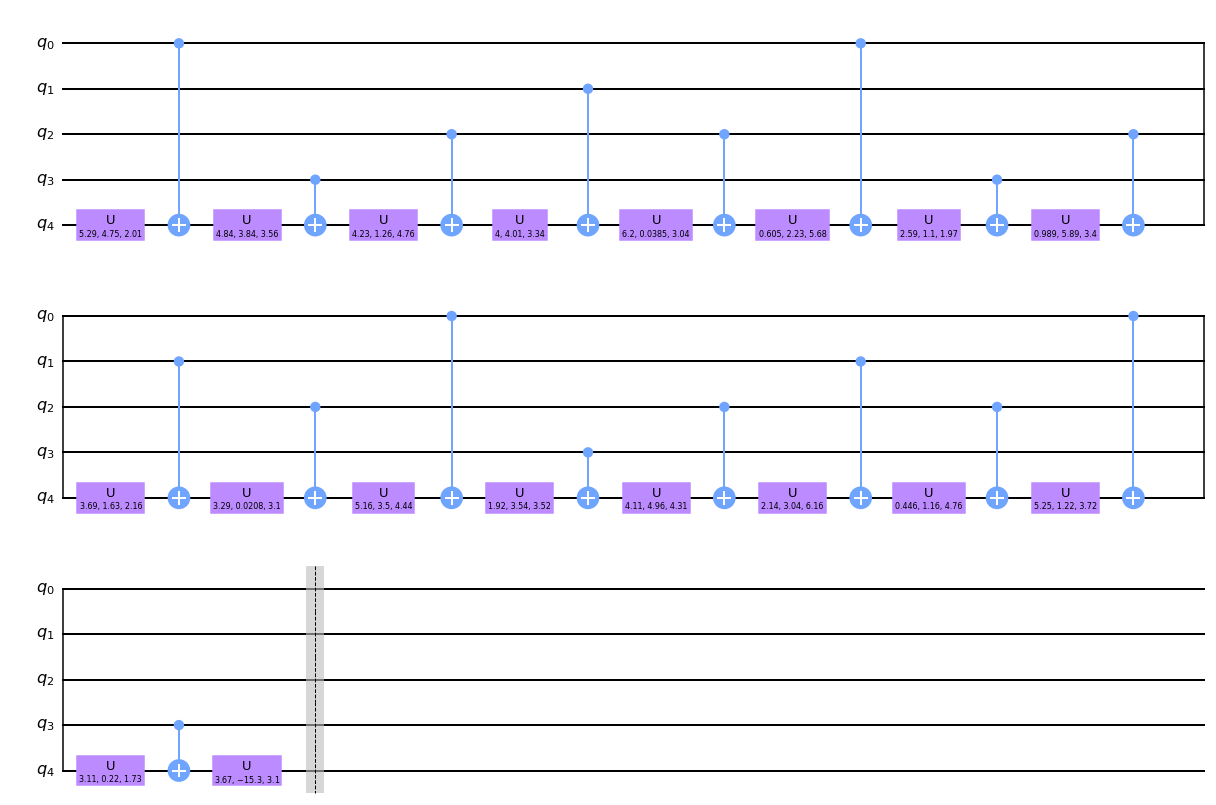

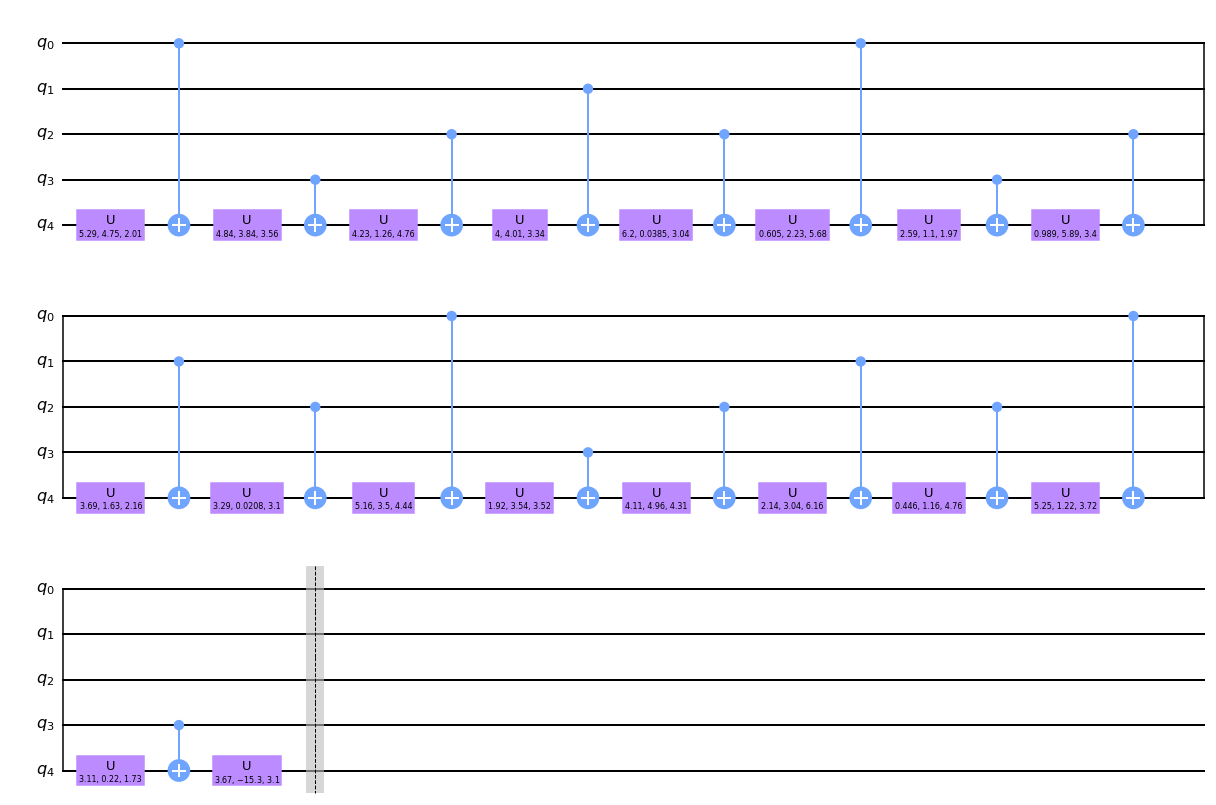

In [16]:
# Draw Circuit

circ = general_circ(n, order, result.x)

circ.barrier()

milk(circ)

In [17]:
# View Unitary
view(np.abs(get(circ, nice = False)))

Matrix([
[0.9999999403,          0.0,          0.0,          0.0,      0.0,          0.0,         0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,      0.0,      0.0, 0.0003456092,          0.0,          0.0,          0.0,      0.0,          0.0,         0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,      0.0,      0.0],
[         0.0, 0.9999999596,          0.0,          0.0,      0.0,          0.0,         0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,      0.0,      0.0,          0.0, 0.0002841246,          0.0,          0.0,      0.0,          0.0,         0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,      0.0,      0.0],
[         0.0,          0.0, 0.9977567114,          0.0,      0.0,          0.0,         0.0,          0.0,          0.0,          0.0,        

In [18]:
general_cost(result.x)

0.003325610644075726